In [15]:
import numpy as np
import cupy as cp

import matplotlib.pyplot as plt
from PIL import Image

from load_dataset import load_dataset

import pandas as pd

In [2]:
# set path vars

#dataset_path = "C:\\Users\\user\\PycharmProjects\\my_cnn\\mnist_png"
dataset_path = 'mnist_png'

In [3]:
# activation functions and their derivatives

# sigmoid
def sigmoid(x):
    return 1/(1+cp.exp(-x))

#sigmoid derivative
def sigmoid_d(x):
    return cp.exp(-x) / cp.power(1 + cp.exp(-x), 2.)

In [4]:
# load the MNIST dataset

dataset = load_dataset(dataset_path)
X = dataset['train']['X']
Y = dataset['train']['Y']

In [5]:
# convert X, Y to CuPy arrays

X = cp.array(X)
Y = cp.array(Y)

In [6]:
# set the layer sizes

layer_sizes = [
    X.shape[0],
    500,
    100,
    10
]

In [7]:
# initialize parameters

W1 = cp.random.randn(layer_sizes[1], layer_sizes[0])
b1 = cp.zeros((layer_sizes[1], 1))

W2 = cp.random.randn(layer_sizes[2], layer_sizes[1])
b2 = cp.zeros((layer_sizes[2], 1))

W3 = cp.random.randn(layer_sizes[3], layer_sizes[2])
b3 = cp.zeros((layer_sizes[3], 1))

In [50]:
# train the model

iterations = 2500
print_cost = True

samples = X.shape[1] # number of training samples (60000 here)

learning_rate = 0.000001

costs = []

for i in range(iterations):

    # forward propagation
    #   push input data through the network
    Z1 = cp.dot(W1, X) + b1
    A1 = sigmoid(Z1)

    Z2 = cp.dot(W2, A1) + b2
    A2 = sigmoid(Z2)

    Z3 = cp.dot(W3, A2) + b3
    A3 = sigmoid(Z3)

    # MSE
    #   cost function, to compute the error
    cost = cp.sum(cp.power(Y - A3, 2.)) / samples
    # cost = -1 / samples * sum([Y[0][i] * cp.log(A3[0][i]) + (1 - Y[0][i]) * cp.log(1 - AL[0][i]) for i in range(AL.shape[1])])
    costs.append(float(cp.squeeze(cost)))

    if print_cost and i % 10 == 0:
        print('Cost: {} @ i = {}'.format(cost, i))


    # backward propagation
    #   adjust the weights and biases to fit the data

    # compute the derivatives of the weights and biases
    # dW3
    dA3 = 2 * (Y - A3)
    dZ3 = sigmoid_d(A3)
    dW3 = cp.dot(dA3 * dZ3, A2.T)
    db3 = cp.sum(dZ3, axis=1, keepdims=True)

    # dW2
    dA2 = cp.dot(W3.T, dA3 * dZ3)
    dZ2 = sigmoid_d(A2)
    dW2 = cp.dot(dA2 * dZ2, A1.T)
    db2 = cp.sum(dZ2, axis=1, keepdims=True)

    # dW1
    dA1 = cp.dot(W2.T, dA2 * dZ2)
    dZ1 = sigmoid_d(A1)
    dW1 = cp.dot(dA1 * dZ1, X.T)
    db1 = cp.sum(dZ1, axis=1, keepdims=True)


    # update parameters
    W1 += learning_rate * dW1
    W2 += learning_rate * dW2
    W3 += learning_rate * dW3

    b1 += learning_rate * db1
    b2 += learning_rate * db2
    b3 += learning_rate * db3

Cost: 0.44793895870059713 @ i = 0
Cost: 0.44742829927854705 @ i = 10
Cost: 0.44702916413130794 @ i = 20
Cost: 0.4467162471174245 @ i = 30
Cost: 0.44645300149786216 @ i = 40
Cost: 0.4461995724489364 @ i = 50
Cost: 0.4459257433913557 @ i = 60
Cost: 0.44561898222073154 @ i = 70
Cost: 0.4452823116185733 @ i = 80
Cost: 0.44492053056558317 @ i = 90
Cost: 0.44452711079452495 @ i = 100
Cost: 0.4440828652852264 @ i = 110
Cost: 0.4435630965112233 @ i = 120
Cost: 0.4429416416388346 @ i = 130
Cost: 0.44221813937199017 @ i = 140
Cost: 0.44143241324092153 @ i = 150
Cost: 0.44062338496980336 @ i = 160
Cost: 0.43979825503135883 @ i = 170
Cost: 0.43895768738791013 @ i = 180
Cost: 0.4381131865750824 @ i = 190
Cost: 0.4372860986583178 @ i = 200
Cost: 0.4365041122973866 @ i = 210
Cost: 0.435793621829276 @ i = 220
Cost: 0.4351690010770355 @ i = 230
Cost: 0.4346323172888036 @ i = 240
Cost: 0.43416985009543524 @ i = 250
Cost: 0.433751544994045 @ i = 260
Cost: 0.4333440010495357 @ i = 270
Cost: 0.432928483865

KeyboardInterrupt: 

In [8]:
# predict

def predict(X):
    Z1 = cp.dot(W1, X) + b1
    A1 = sigmoid(Z1)

    Z2 = cp.dot(W2, A1) + b2
    A2 = sigmoid(Z2)

    Z3 = cp.dot(W3, A2) + b3
    A3 = sigmoid(Z3)

    return A3

0 [0.00376376]
1 [0.00301685]
2 [0.04853541]
3 [0.00701581]
4 [0.67970816]
5 [0.10858257]
6 [0.00303651]
7 [0.00966378]
8 [0.00989911]
9 [0.2246295]
The system predicted:  4


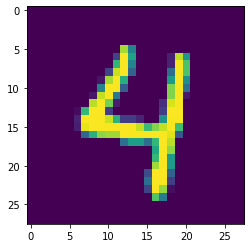

In [56]:
# load a sample image from the test dataset
# to evaluate the model

img = np.asarray(
        Image.open(
            dataset_path + "/testing/4/27.png"
        )
    )
plt.imshow(img)
img = img.reshape((img.shape[0] * img.shape[1]))[:, cp.newaxis]

X_n = img

# to CuPy
X_n = cp.array(X_n) / 255

# predict it
prediction = predict(X_n)
[print(index, p)for index, p in enumerate(list(prediction))]
print('The system predicted: ', list(prediction).index(max(list(prediction))))

In [52]:
# validate

Y_prediction_train = predict(cp.array(dataset['train']['X']))
Y_train = cp.array(dataset['train']['Y'])

Y_prediction_test = predict(cp.array(dataset['test']['X']))
Y_test = cp.array(dataset['test']['Y'])

print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

train accuracy: 90.20738554603417 %
test accuracy: 90.2189643947789 %


In [48]:
# save weights and biases

W1_df = pd.DataFrame(cp.asnumpy(W1))
W2_df = pd.DataFrame(cp.asnumpy(W2))
W3_df = pd.DataFrame(cp.asnumpy(W3))

b1_df = pd.DataFrame(cp.asnumpy(b1))
b2_df = pd.DataFrame(cp.asnumpy(b2))
b3_df = pd.DataFrame(cp.asnumpy(b3))

[df.to_csv('cache/W/' + name) for df, name in zip(
    (W1_df, W2_df, W3_df),
    ('w1.csv', 'w2.csv', 'w3.csv'))]

[df.to_csv('cache/b/' + name) for df, name in zip(
    (b1_df, b2_df, b3_df),
    ('b1.csv', 'b2.csv', 'b3.csv'))]

[None, None, None]

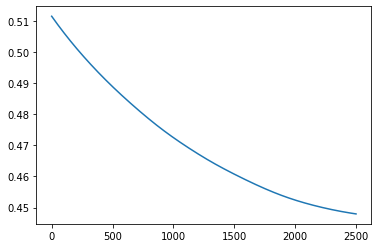

In [38]:
# plot
plt.plot(range(iterations), costs)
plt.show()
